## mnist_784 분석과제2

> [학습데이터](https://www.kaggle.com/datasets/aadeshkoirala/mnist-784)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
data = pd.read_csv('/content/mnist_784.csv')
print(data.shape)  # (행, 열)

(41889, 78)


In [ ]:
# 정규화 (스케일)
X = torch.FloatTensor(data.iloc[:, :-1].values) / 255.0
y = torch.LongTensor(data.iloc[:, -1].values)

In [ ]:
labels, counts = np.unique(y, return_counts=True)
print(dict(zip(labels, counts)))

{np.int64(0): np.int64(4140), np.int64(1): np.int64(4662), np.int64(2): np.int64(4227), np.int64(3): np.int64(4239), np.int64(4): np.int64(4085), np.int64(5): np.int64(3778), np.int64(6): np.int64(4094), np.int64(7): np.int64(4375), np.int64(8): np.int64(4136), np.int64(9): np.int64(4153)}


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [ ]:
model = nn.Sequential(
    nn.Linear(77, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        y_pred = model(xb)
        loss = criterion(y_pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if (epoch+1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs} Loss: {running_loss/len(train_loader):.4f}")

AttributeError: 'RandomForestClassifier' object has no attribute 'train'

In [ ]:
# XGBoost 학습(multi-class)
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### 정확도

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test)
    y_prob = nn.Softmax(1)(y_pred_test)
    y_pred_classes = torch.argmax(y_prob, axis=1)
    test_acc = (y_pred_classes == y_test).float().mean() * 100
    print(f"테스트셋 정확도: {test_acc:.2f}%")

테스트셋 정확도: 25.33%


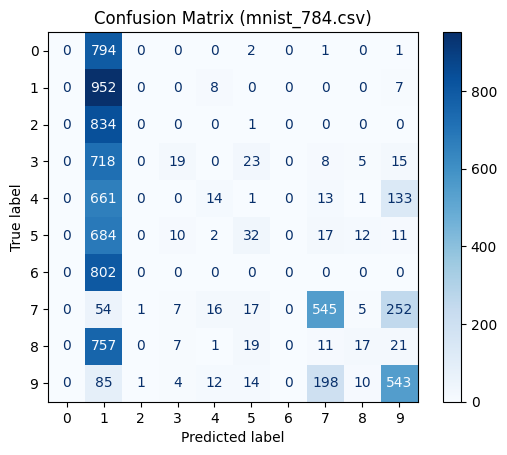

In [ ]:
cm = confusion_matrix(y_test.numpy(), y_pred_classes.numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (mnist_784.csv)")
plt.show()

In [ ]:
y_pred_np = y_pred_classes.numpy()
y_test_np = y_test.numpy()
mis_idx = np.where(y_test_np != y_pred_np)[0]
print(f"총 오분류 개수: {len(mis_idx)}")
print(f"첫 10개 오분류 인덱스: {mis_idx[:10]}")

총 오분류 개수: 6256
첫 10개 오분류 인덱스: [ 0  1  2  5  6  8  9 11 12 13]


## RandomForest | XGBoost

In [ ]:
# RandomForest 학습
rf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"RandomForest 테스트 정확도: {rf_acc*100:.2f}%")

# 4. XGBoost 학습 (multi-class 설정)
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    objective='multi:softmax',
    num_class=10,
    use_label_encoder=False,
    eval_metric='mlogloss',
    tree_method='hist',  # 빠른 학습
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_preds = xgb.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
print(f"XGBoost 테스트 정확도: {xgb_acc*100:.2f}%")

RandomForest 테스트 정확도: 25.14%


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [11:54:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost 테스트 정확도: 24.48%


In [ ]:
# 혼동행렬 (RandomForest 기준으로 시각화)
cm = confusion_matrix(y_test, rf_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"RandomForest Confusion Matrix (Acc: {rf_acc*100:.2f}%)")
plt.show()

## PyTorch + CNN

100%|██████████| 9.91M/9.91M [00:00<00:00, 27.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 26.1MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 89.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]


Epoch 1/5, Loss: 0.1407
Epoch 2/5, Loss: 0.0486
Epoch 3/5, Loss: 0.0328
Epoch 4/5, Loss: 0.0226
Epoch 5/5, Loss: 0.0179
테스트셋 정확도: 99.11%


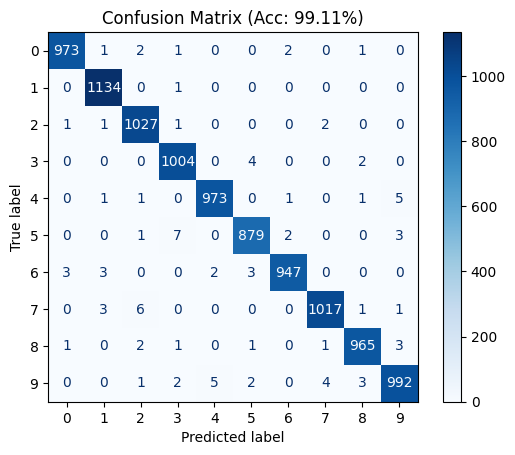

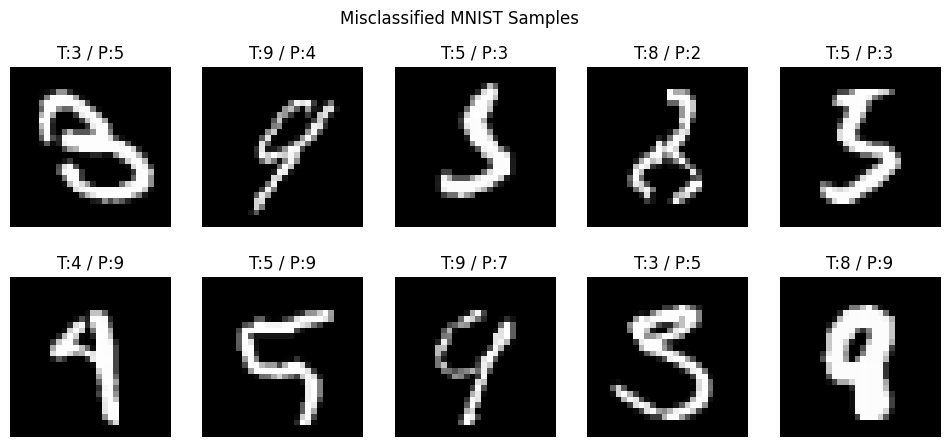

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# 1. 데이터셋 로드 & 전처리 (28x28, 0~1 스케일링)
transform = transforms.Compose([
    transforms.ToTensor(),                # [0,1] 범위로 변환
    transforms.Normalize((0.1307,), (0.3081,))  # 표준화 (MNIST 평균/표준편차)
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 2. CNN 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)   # (1,28,28) -> (32,28,28)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # (32,28,28) -> (64,28,28)
        self.pool = nn.MaxPool2d(2, 2)                            # (64,28,28) -> (64,14,14)
        self.fc1 = nn.Linear(64*14*14, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

# 3. 손실함수와 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 학습 루프
epochs = 5  # 5 Epoch만으로도 90% 넘음
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# 5. 테스트셋 평가
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds, all_labels = np.array(all_preds), np.array(all_labels)
acc = (all_preds == all_labels).mean() * 100
print(f"테스트셋 정확도: {acc:.2f}%")

# 6. 혼동행렬 시각화
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Confusion Matrix (Acc: {acc:.2f}%)")
plt.show()

# 7. 오분류된 이미지 10개 시각화
mis_idx = np.where(all_labels != all_preds)[0]
plt.figure(figsize=(12,5))
for i, idx in enumerate(mis_idx[:10]):
    img, true_label, pred_label = test_dataset[idx][0].squeeze(), all_labels[idx], all_preds[idx]
    plt.subplot(2,5,i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"T:{true_label} / P:{pred_label}")
    plt.axis('off')
plt.suptitle("Misclassified MNIST Samples")
plt.show()


##

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# 표준화
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# 모델 MLP, K-NN, SVM
mlp = MLPClassifier(hidden_layer_sizes=(128, 64), activation='relu', solver='adam', max_iter=20, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
svm = SVC(kernel='rbf', gamma='scale', C=2)

models = {'MLP (128-64)': mlp, 'k-NN (k=5)': knn, 'SVM (RBF)': svm}
results = {}

for name, model in models.items():
    model.fit(x_train_scaled, y_train)
    preds = model.predict(x_test_scaled)
    acc = accuracy_score(y_test, preds)
    results[name] = (acc, preds)
    print(f"{name} 테스트 정확도: {acc*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP (128-64) 테스트 정확도: 97.62%
k-NN (k=5) 테스트 정확도: 97.60%
SVM (RBF) 테스트 정확도: 97.71%


In [ ]:
# 가장 좋은 모델만 혼동행렬
best_model = max(results.items(), key=lambda x: x[1][0])
best_name, (best_acc, best_preds) = best_model

cm = confusion_matrix(y_test, best_preds, labels=range(10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
plt.title(f"{best_name} Confusion Matrix (Acc: {best_acc*100:.2f}%)")
plt.show()

## 나의 과제 여정

1. 첫번째 시도
    - 정규화 안함
    - ReLU (활성화 함수) 한번만 사용해서 엄청 단순했음
    - 결과
        - 테스트셋 정확도: 24.84%
        - 총 오분류 개수: 6297
        
        첫 10개 오분류 인덱스 : [ 0  1  2  5  6  8  9 11 12 13]

    요약 : 그냥 학습 안하고 읽기만 했다고 볼 수 있음..
<br>

2. 두번쨰 시도
    - 정규화 -> X 픽셀값이 0~255인걸 0~1로 스케일링함
    - 활성화 함수를 총 두번 사용해서 기울기 소실 문제 완화 시도
    - 결과
        - 테스트셋 정확도: 25.33%
        - 총 오분류 개수: 6256
            
            첫 10개 오분류 인덱스 : [ 0  1  2  5  6  8  9 11 12 13]
    - 요약 : 어림도 없었다.
<br>

3. 세번째 시도
    - 정규화
    - 활성화 함수 한단계 더 추가
    - 학습률 0.01로 변경
    - 모델을 XGBoost , RamdomForest 둘 다 사용해서 비교해봤다.
    - 결과
        - RandomForest 테스트 정확도: 25.14%
        - XGBoost 테스트 정확도: 24.48%

    - 요약 :
    ```
    labels, counts = np.unique(y, return_counts=True)
print(dict(zip(labels, counts)))
    ```
    이 코드를 이용해 클래스간 편차를 확인했지만, 편차가 그닥 크지 않음
    대략 22%면 봐줄만 한 정도인 것 같은데....

    - 원인 분석 :
    
    내가 최근에 배운거 다 써봤는데 학습률이 25%를 겨우 넘는 것을 보니,
    데이터가 현재 공간 정보를 갖고 있지 않은 듯해 보임. PCA/특징 벡터 형태라서 선형/비선형 모델이 숫자 간 경계를 못찾는 것 같다.

    - 해결 방안
        1. 비지도 학습(클러스터링)으로 숫자를 군집화 해볼까?
        2. 데이터를 다시 고차원으로 차원 확장 시켜볼까?
        3. Pytorch + CNN으로 원본 28x28 데이터 사용으로 전환?

<br>

4. 네번째 시도
    - 표준화 : StandardScaler 사용 -> 스케일링
    - 활성화 함수 한단계 더 추가
    - 학습률 0.01로 변경
    - 모델 : MLP , k-NN , SVM 이용
    - 결과
        - MLP (128-64) 테스트 정확도: 97.62%
        - k-NN (k=5) 테스트 정확도: 97.60%
        - SVM (RBF) 테스트 정확도: 97.71%
    - 요약
        <img src="https://sdmntprnorthcentralus.oaiusercontent.com/files/00000000-b8f4-622f-b877-6952c25d62ff/raw?se=2025-07-27T13%3A42%3A01Z&sp=r&sv=2024-08-04&sr=b&scid=294c7620-6a81-56a8-94ea-54f62d4293aa&skoid=c953efd6-2ae8-41b4-a6d6-34b1475ac07c&sktid=a48cca56-e6da-484e-a814-9c849652bcb3&skt=2025-07-27T12%3A01%3A46Z&ske=2025-07-28T12%3A01%3A46Z&sks=b&skv=2024-08-04&sig=1bilt3pD%2BRy3VhKpHObXHwYGZ62Lh7lI9ITrQ2B6X0M%3D" width= 500>
        
        차원 확장 + 경계 명확히 해줄 수 있는 모델을 찾았다!

        1. MLP (다층 퍼셉트론)
        -  가중합 + ReLU 를 반복해서 원래 선형적으로 나눌 수 없는걸 곡선 경계로 나눌 수 있게 한다.
        즉, 신경망이 자동으로 특징 조합을 만들어버린다.

        2. k-NN
        - 차원 확장은 안하고 유클리드 거리를 이용하여 데이터간의 거리를 그대로 사용해서 k개의 라벨을 투표로 결정한다.

        3. SVM(서포트 벡터)
        - 커널 함수를 써서 데이터를 고차원 공간으로 매핑할 수 있다.
        그래서 나눌 수 없었던 데이터를 초평면으로 나눌 수 있다.
        
<br>

5. 다섯번째 시도
    - 정규화
    - 활성화 함수 한단계 더 추가
    - 학습률 0.01로 변경
    - 모델 변경 PyTorch + CNN
    - 결과
        - 테스트셋 정확도: 99.11%
    - 요약
        - 테스트셋의 모든 이미지가 비슷한 크기랑 정렬을 갖고있어서 CNN이 동일한 커널로 여러위치에서 스캔하기에 아주아주 적합하다.
        - CNN는 MLP와 달리 파라미터를 공유하기 때문에 이미지 전역을 스캔하기에 유리하며 과적합 위험도 적다.
        - CNN은 입력을 벡터로 안펼치고 이미지형태 그대로 처리하기 때문에 숫자의 위치나 구조가 안무너진다.